# GARNET for Jet-Images ( Thea's Version )
## 

In [1]:
#!fusermount -u drive
#! pip install einops

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
#data_dir = '/content/gdrive/My Drive/Colab Notebooks/Data/'
data_dir = '/Users/sznajder/cernbox/WorkM1/tensorflow_macos/arm64/workdir/data/hls4ml_LHCjet_150p_val/'

# Load HLS4ML dataset 

## Here, we load the numpy arrays containing the 4D tensors of "jet-images" (see https://arxiv.org/pdf/1511.05190.pdf)

## https://github.com/pierinim/tutorials/blob/master/GGI_Jan2021/Lecture1/Notebook1_ExploreDataset.ipynb

 * 'jetImage' contains the image representation of the jets (more later)

 * 'jetImageECAL' and 'jetImageHCAL' are the ECAL- and HCAL-only equivalent images. We will not use them (but you are more than welcome to play with it)

 * 'jetConstituentList' is the list of particles cointained in the jet. For each particle, a list of relevant quantities is stored

 * 'particleFeatureNames' is the list of the names corresponding to the quantities contained in 'jetConstituentList' 'jets' is the dataset we consider for the moment

 * 'jetFeatureNames' is the list of the names corresponding to the quantities contained in 'jets'


In [3]:
import numpy as np
import h5py
import os

#Data PATH
TRAIN_PATH = '/Users/sznajder/WorkM1/workdir/data/hls4ml_LHCjet_150p/'

# Prepare the DATA
#target = np.array([])
#jetConstituent = np.array([])
#jetImage = np.array([])

first=True
for file in os.listdir(TRAIN_PATH):
  print("Appending %s" %file)

  with h5py.File(TRAIN_PATH+file, 'r') as data:
    if first : 
        first=False
        jetConstituent = data['jetConstituentList'][:,:,[5,8,11]]  # 
#        jetImage= data['jetImage'][:,:,:] 
        target = data['jets'][:,-6:-1]
    
        print("Keys in H5PY files = ",list( data.keys() ))
        print(" ")
        featurenames = data.get('jetFeatureNames')
        print("Jets Features = ",featurenames[:])
        # the b is due to the byte vs utf-8 encoding of the strings in the dataset
        # just ignore them for the moment
        print(" ")
        featurenames = data.get('particleFeatureNames')
        print("Jet Constituents Features = ",featurenames[:])
        print(" ")
        images = data.get('jetImage')
        print("Jet Images = ",images[:])        
        print("Jet Image Shape = ",images.shape)   
        print(" ")

    else:
         # Read (Pt,Etarel,Phirel)
        jetConstituent = np.concatenate( [ jetConstituent, data['jetConstituentList'][:,:,[5,8,11]] ] , axis=0 )
         # Read (Pt,Eta,Phi)
#        jetConstituent = np.concatenate( [ jetConstituent, data['jetConstituentList'][:,:,[5,7,10]] ] , axis=0 )
#        jetImage = np.concatenate( [ jetImage, data['jetImage']    ] , axis=0 )
        target   = np.concatenate( [ target, data['jets'][:,-6:-1] ] , axis=0 )




print("Target shape =", target.shape)
print("Jet Constituents list shape =", jetConstituent.shape)


Appending jetImage_6_150p_40000_50000.h5
Keys in H5PY files =  ['jetConstituentList', 'jetFeatureNames', 'jetImage', 'jetImageECAL', 'jetImageHCAL', 'jets', 'particleFeatureNames']
 
Jets Features =  [b'j_ptfrac' b'j_pt' b'j_eta' b'j_mass' b'j_tau1_b1' b'j_tau2_b1'
 b'j_tau3_b1' b'j_tau1_b2' b'j_tau2_b2' b'j_tau3_b2' b'j_tau32_b1'
 b'j_tau32_b2' b'j_zlogz' b'j_c1_b0' b'j_c1_b1' b'j_c1_b2' b'j_c2_b1'
 b'j_c2_b2' b'j_d2_b1' b'j_d2_b2' b'j_d2_a1_b1' b'j_d2_a1_b2' b'j_m2_b1'
 b'j_m2_b2' b'j_n2_b1' b'j_n2_b2' b'j_tau1_b1_mmdt' b'j_tau2_b1_mmdt'
 b'j_tau3_b1_mmdt' b'j_tau1_b2_mmdt' b'j_tau2_b2_mmdt' b'j_tau3_b2_mmdt'
 b'j_tau32_b1_mmdt' b'j_tau32_b2_mmdt' b'j_c1_b0_mmdt' b'j_c1_b1_mmdt'
 b'j_c1_b2_mmdt' b'j_c2_b1_mmdt' b'j_c2_b2_mmdt' b'j_d2_b1_mmdt'
 b'j_d2_b2_mmdt' b'j_d2_a1_b1_mmdt' b'j_d2_a1_b2_mmdt' b'j_m2_b1_mmdt'
 b'j_m2_b2_mmdt' b'j_n2_b1_mmdt' b'j_n2_b2_mmdt' b'j_mass_trim'
 b'j_mass_mmdt' b'j_mass_prun' b'j_mass_sdb2' b'j_mass_sdm1'
 b'j_multiplicity' b'j_g' b'j_q' b'j_w' b'j_z' b'

# The ground truth is incorporated in the ['g', 'q', 'w', 'z', 't'] vector of boolean, taking the form
 
## [1, 0, 0, 0, 0] for gluons
 
## [0, 1, 0, 0, 0] for quarks
 
## [0, 0, 1, 0, 0] for Ws
 
## [0, 0, 0, 1, 0] for Zs
 
## [0, 0, 0, 0, 1] for tops

## This is what is called 'one-hot' encoding of a descrete label (typical of ground truth for classification problems)



In [4]:
from einops import rearrange, reduce, repeat

# Convert target format from one-hot encoding to single neuron
#target = np.argmax(target, axis=1)

# 1st dim is jet image index
# 2nd dim is image eta bin
# 3rd dim is image phi bin
njet = jetConstituent.shape[0]
nconstit = jetConstituent.shape[1]
nfeat = jetConstituent.shape[2]

print('Shape of jetConstituent =',jetConstituent.shape)
print('Number of jets =',njet)
print('Number of constituents =',nconstit)
print('Number of features =',nfeat)

# Filter out constituents with Pt<2GeV
Ptmin =2. 
constituents = np.zeros((njet, nconstit, nfeat) , dtype=np.float32) 
ij=0
max_constit=0
for j in range(njet):
    ic=0
    for c in range(nconstit):
        if ( jetConstituent[j,c,0] < Ptmin ):
            continue
        constituents[ij,ic,:] = jetConstituent[j,c,:] 
        ic+=1
    if (ic > 0):
        if ic > max_constit: max_constit=ic
        target[ij,:]=target[j,:] # assosicate the correct target a given graph 
        ij+=1


# Resizes the jets constituents and target arrays        
jetConstituent = constituents[0:ij,0:max_constit,:]
target = target[0:ij,:]


# Restric the number of constituents to a maximum of NMAX
nmax = 16
jetConstituent = jetConstituent[:,0:nmax,:]

# The dataset is N_jets x N_constituents x N_features
njet     = jetConstituent.shape[0]
nconstit = jetConstituent.shape[1]
nfeat    = jetConstituent.shape[2]

print('Number of jets =',njet)
print('Number of constituents =',nconstit)
print('Number of features =',nfeat)


# Shuffles jet constituents
print("Before --->> jetConstituent[0,0:4,0] = ",jetConstituent[0,0:4,0])
for i in range(jetConstituent.shape[0]):
  jetConstituent[i] = jetConstituent[i, np.random.permutation(nconstit), :]
print("After --->> jetConstituent[0,0:4,0] = ",jetConstituent[0,0:4,0])



Shape of jetConstituent = (880000, 150, 3)
Number of jets = 880000
Number of constituents = 150
Number of features = 3
Number of jets = 880000
Number of constituents = 16
Number of features = 3
Before --->> jetConstituent[0,0:4,0] =  [118.65741  113.409935 113.007545 104.92594 ]
After --->> jetConstituent[0,0:4,0] =  [113.409935  39.23477   29.3719    53.66348 ]


## Dividing the data into testing and training dataset

We will split the data into two parts (one for training+validation and one for testing) 

In [5]:
from sklearn.model_selection import train_test_split

X = jetConstituent
Y = target
del jetConstituent , target

X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

print(X_train_val.shape, X_test.shape, Y_train_val.shape, Y_test.shape)

print('number of G jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==0 ))
print('number of Q jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==1 ))
print('number of W jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==2 ))
print('number of Z jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==3 ))
print('number of T jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==4 ))


print('number of G jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==0 ))
print('number of Q jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==1 ))
print('number of W jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==2 ))
print('number of Z jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==3 ))
print('number of T jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==4 ))




(589600, 16, 3) (290400, 16, 3) (589600, 5) (290400, 5)
number of G jets for training/validation: 118789
number of Q jets for training/validation: 114175
number of W jets for training/validation: 118845
number of Z jets for training/validation: 118615
number of T jets for training/validation: 119176
number of G jets for testing: 58463
number of Q jets for testing: 56504
number of W jets for testing: 58327
number of Z jets for testing: 58337
number of T jets for testing: 58769


## GARNET implementation ( Thea's version )

In [13]:
#from garnet import *
from tensorflow.keras import metrics, Model
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
import tensorflow.keras as keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Input, Activation, Dense, Dropout, BatchNormalization, Flatten
from qkeras import *
# Thea's version of GARNET
from garnet_hls4ml_compat import *


K = keras.backend

#vmax = nconstit
vmax = 8

'''
# Garnet layers for 32 constituents
n_aggregators = 20
n_filters     = 5
n_propagate   = 5
n_dense       = 25
'''

'''
# Garnet layers for 16 constituents
n_aggregators = 20
n_filters     = 9
n_propagate   = 5
n_dense       = 28
'''

#'''
# Garnet layers for 8 constituents
n_aggregators = 20
n_filters     = 10
n_propagate   = 10
n_dense       =32
#'''



###############################################################
# Quantized bits
nbits=8
integ=0

#qbits = quantized_bits(nbits,integ,alpha=1.0)
#qact = 'quantized_relu('+str(nbits)+',0)'

# Set QKeras quantizer and activation 
if nbits == 1:
    qbits = 'binary(alpha=1)'
elif nbits == 2:
    qbits = 'ternary(alpha=1)'
else:
    qbits = 'quantized_bits({},{},alpha=1)'.format(nbits,integ)

qact = 'quantized_relu({},{})'.format(nbits,integ)

print("Quantization with nbits=",nbits," with integer part=",integ)

###############################################################

# Garnet Model

x = Input(shape=(nconstit, nfeat), name="inpx")
n = Input(shape=(1,), dtype='uint16', name="inpn")
vmax = nconstit
inp = [x, n]

xx = BatchNormalization(name='batchnorm')(inp[0])
nn = inp[1]

v = GarNet(n_aggregators, n_filters, n_propagate, simplified=True, input_format='xn',
           output_activation=None, name='gar_1', quantize_transforms=True, 
           kernel_quant=qbits, bias_quant=qbits)([xx,nn])

#################################################################


v = Flatten()(v)
v = QActivation(qact, name='qrelu0')(v)
#v = Flatten()(v)


v = QDense(n_dense, kernel_quantizer=qbits, bias_quantizer=qbits, name='qdense1')(v)
v = QActivation(qact, name='qrelu1')(v)

#v = QDense(n_dense, kernel_quantizer=qbits, bias_quantizer=qbits, name='qdense2')(v)
#v = QActivation(qact, name='qrelu2')(v)

#v = QDense(n_dense, kernel_quantizer=qbits, bias_quantizer=qbits, name='qdense3')(v)
#v = QActivation(qact, name='qrelu3')(v)

out = QDense(5, kernel_quantizer=qbits, bias_quantizer=qbits, name='qdense4')(v)
out = Activation('softmax',name='softmx')(out)

###############################################################

# Build the model
model = Model(inputs=inp, outputs=out)

# Compile the model
optim = Adam(learning_rate=0.0002)
model.compile(optimizer=optim, loss='categorical_crossentropy',metrics=['categorical_accuracy'])

# print the model summary
model.summary()

Quantization with nbits= 8  with integer part= 0
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inpx (InputLayer)               [(None, 16, 3)]      0                                            
__________________________________________________________________________________________________
batchnorm (BatchNormalization)  (None, 16, 3)        12          inpx[0][0]                       
__________________________________________________________________________________________________
inpn (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
gar_1 (GarNet)                  (None, 16, 9)        1009        batchnorm[0][0]                  
                                           

# Define the Model and Compile 


## Run training
Here, we run the training.

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau,TerminateOnNaN 

# early stopping callback
est = EarlyStopping(monitor='val_loss', patience=10)

# Learning rate scheduler 
lrs = ReduceLROnPlateau(monitor='val_loss',factor=0.1, patience=5)

# model checkpoint callback
# this saves our model architecture + parameters into mlp_model.h5
model_checkpoint = ModelCheckpoint('Garnet_arpita.h5', monitor='val_loss', 
                                   verbose=0, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   save_freq=1)

# Train classifier
V_train_val =  np.ones((X_train_val.shape[0],1))*vmax
history = model.fit( [ X_train_val, V_train_val ] , Y_train_val, 
                    epochs=150, 
                    batch_size=512, 
                    verbose=1,
                    callbacks=[lrs , est, TerminateOnNaN()], 
                    validation_split=0.33 )
                    
#                    callbacks=[early_stopping, model_checkpoint], 

# Set model and output name
arch = 'QGarnet'
fname = arch+'_nconst_'+str(nmax)+'_nbits_'+str(nbits)
print('Saving Model : ',fname)


# Save the model
model.save('model_'+fname+'.h5')

## Save the model weights in a separate file
model.save_weights('weights_'+fname+'.h5')

Epoch 1/150
772/772 [==============================] - 6s 8ms/step - loss: 1.3495 - categorical_accuracy: 0.4301 - val_loss: 1.1752 - val_categorical_accuracy: 0.5289
Epoch 2/150
772/772 [==============================] - 6s 8ms/step - loss: 1.1050 - categorical_accuracy: 0.5633 - val_loss: 1.0690 - val_categorical_accuracy: 0.5821
Epoch 3/150
772/772 [==============================] - 6s 8ms/step - loss: 1.0436 - categorical_accuracy: 0.5984 - val_loss: 1.0245 - val_categorical_accuracy: 0.6054
Epoch 4/150
772/772 [==============================] - 6s 8ms/step - loss: 1.0062 - categorical_accuracy: 0.6172 - val_loss: 0.9928 - val_categorical_accuracy: 0.6248
Epoch 5/150
772/772 [==============================] - 7s 9ms/step - loss: 0.9800 - categorical_accuracy: 0.6296 - val_loss: 0.9756 - val_categorical_accuracy: 0.6373
Epoch 6/150
772/772 [==============================] - 7s 9ms/step - loss: 0.9584 - categorical_accuracy: 0.6401 - val_loss: 0.9472 - val_categorical_accuracy: 0.649

## Plot performance
Here, we plot the history of the training and the performance in a ROC curve

(array([0., 1.]), array([231937,  58463]))
(array([0., 1.]), array([233896,  56504]))
(array([0., 1.]), array([232073,  58327]))
(array([0., 1.]), array([232063,  58337]))
(array([0., 1.]), array([231631,  58769]))


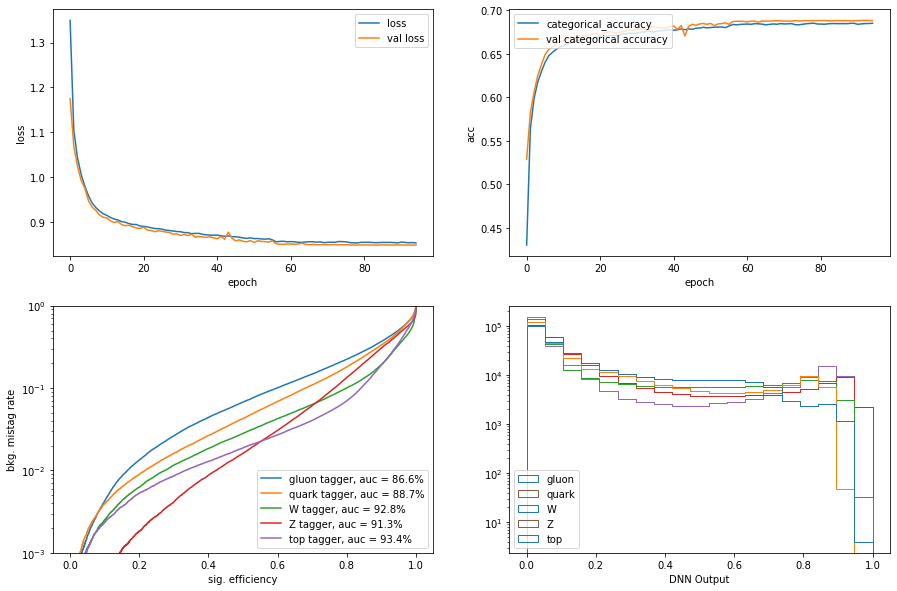

In [15]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

#plt.rcParams['axes.unicode_minus'] = False

# Plot loss vs epoch
plt.figure(figsize=(15,10))
ax = plt.subplot(2, 2, 1)
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val loss')
ax.legend(loc="upper right")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

# Plot accuracy vs epoch
ax = plt.subplot(2, 2, 2)
#ax.plot(history.history['accuracy'], label='accuracy')
#ax.plot(history.history['val_accuracy'], label='val accuracy')
ax.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
ax.plot(history.history['val_categorical_accuracy'], label='val categorical accuracy')
ax.legend(loc="upper left")
ax.set_xlabel('epoch')
ax.set_ylabel('acc')

# Plot the ROC curves
labels = ['gluon', 'quark', 'W', 'Z', 'top']
fpr = {}
tpr = {}
auc1 = {}
precision = {}
recall = {}
NN = {}
NP = {}
TP = {}
FP = {}
TN = {}
FN = {}
tresholds = {}


ax = plt.subplot(2, 2, 3)

# Get the model predictions
V_test =  np.ones((X_test.shape[0],1))*vmax
Y_predict = model.predict([X_test,V_test])


# Loop over classes(labels) to get metrics per class
for i, label in enumerate(labels):
    fpr[label], tpr[label], tresholds[label] = roc_curve(Y_test[:,i], Y_predict[:,i])
#    precision[label], recall[label], tresholds = precision_recall_curve(Y_test[:,i], Y_predict[:,i]) 
    print( np.unique(Y_test[:,i], return_counts=True) )
    _ , N = np.unique(Y_test[:,i], return_counts=True) # count the NEGATIVES and POSITIVES samples in your test set
    NN[label] = N[0]                   # number of NEGATIVES 
    NP[label] = N[1]                   # number of POSITIVES
    TP[label] = tpr[label]*NP[label]
    FP[label] = fpr[label]*NN[label] 
    TN[label] = NN[label] - FP[label]
    FN[label] = NP[label] - TP[label]

    auc1[label] = auc(fpr[label], tpr[label])
    ax.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))


ax.semilogy()
ax.set_xlabel("sig. efficiency")
ax.set_ylabel("bkg. mistag rate")
ax.set_ylim(0.001,1)
#ax.set_grid(True)
ax.legend(loc='lower right')
#plt.savefig('%s/ROC.pdf'%(options.outputDir))



# Plot DNN output 
ax = plt.subplot(2, 2, 4)
X = np.linspace(0.0, 1.0, 20)
hist={}
for i, name in enumerate(labels):
    hist[name] = ax.hist(Y_predict, bins=X, label=name ,histtype='step')
ax.semilogy()
ax.set_xlabel('DNN Output')
ax.legend(prop={'size': 10})
ax.legend(loc='lower left')

# Display plots
fig = plt.gcf()
plt.show()



In [16]:
from sklearn.metrics import accuracy_score

# Save plots
fig.savefig(fname+'.pdf')


# Save FPR for a given TPR value ( 30% , 50% & 80%)
with open('FPR@TPR_'+fname+'.csv', 'w') as file:
  file.write("model,label,treshold,tpr,fpr\n")
  for label in labels:
    for t in [0.3, 0.5, 0.8]:
      index = np.argmax(tpr[label]>t)
      file.write( arch+','+label+','+str(t)+','+str(tpr[label][index])+','+str(fpr[label][index])+'\n' )
      print("Label = ", label , " with treshold = ",t)
      print("TPR = ",tpr[label][index])
      print("FPR = ",fpr[label][index])
      print(" ")
               
               
# Save ROC AUC for each label
with open('ROCAUC_'+fname+'.csv', 'w') as file:
  header = labels[0]+', '+labels[1]+', '+labels[2]+', '+labels[3]+', '+labels[4]+'\n'
  file.write(header)
  rocauc = str(auc1[labels[0]])+', '+str(auc1[labels[1]])+', '+str(auc1[labels[2]])+', '+str(auc1[labels[3]])+', '+str(auc1[labels[4]])
  file.write(rocauc)


# Save NN Accuracy for treshold of 0.5 for each label and the average over all classes
acc_avg = float(accuracy_score (np.argmax(Y_test,axis=1), np.argmax(Y_predict,axis=1)))
with open('ACCURACY_'+fname+'.csv', 'w') as file:
  header = labels[0]+', '+labels[1]+', '+labels[2]+', '+labels[3]+', '+labels[4]+', '+'acc_avg'+'\n'
  file.write(header)
  accuracy = ''
  for label in labels:  
    idx = np.argmax( tresholds[label] <= 0.5 )
    accuracy += str( (TP[label][idx]+TN[label][idx])/(NP[label]+NN[label]) )+', '
  accuracy += str(acc_avg) 
  file.write(accuracy)
  



Label =  gluon  with treshold =  0.3
TPR =  0.30005302499016473
FPR =  0.026339048965882978
 
Label =  gluon  with treshold =  0.5
TPR =  0.5000427620888425
FPR =  0.06754851532959381
 
Label =  gluon  with treshold =  0.8
TPR =  0.8000102629013222
FPR =  0.22407809017103783
 
Label =  quark  with treshold =  0.3
TPR =  0.30003185615177685
FPR =  0.016169579642234155
 
Label =  quark  with treshold =  0.5
TPR =  0.5000176978620983
FPR =  0.042561651332216024
 
Label =  quark  with treshold =  0.8
TPR =  0.8000141582896786
FPR =  0.18058025789239662
 
Label =  W  with treshold =  0.3
TPR =  0.3000154302467125
FPR =  0.011617034295243307
 
Label =  W  with treshold =  0.5
TPR =  0.5000257170778541
FPR =  0.028124771084960337
 
Label =  W  with treshold =  0.8
TPR =  0.8000240026059973
FPR =  0.10066229160652036
 
Label =  Z  with treshold =  0.3
TPR =  0.30013542005931054
FPR =  0.004141116851889358
 
Label =  Z  with treshold =  0.5
TPR =  0.5000599962288085
FPR =  0.016150786639834873


In [17]:
# Test Loading Garnet model
from tensorflow.keras.models import load_model
'''
# Delete the model and clear session
try:
    del model
    tf.keras.backend.clear_session()
except:
  print("Model not defined")    

model = load_model( 'model_'+fname+'.h5' , custom_objects={"GarNet":GarNet, "QDense":QDense, "QActivation":QActivation,
                                                           "quantized_bits":quantized_bits} )
model.summary()
'''



'\n# Delete the model and clear session\ntry:\n    del model\n    tf.keras.backend.clear_session()\nexcept:\n  print("Model not defined")    \n\nmodel = load_model( \'model_\'+fname+\'.h5\' , custom_objects={"GarNet":GarNet, "QDense":QDense, "QActivation":QActivation,\n                                                           "quantized_bits":quantized_bits} )\nmodel.summary()\n'

In [18]:
from sklearn.metrics import accuracy_score

# Save a sample of events for Thea test on HLS

njets=3000
print(X_test.shape)
np.save('x_test_8const.npy', X_test[0:njets,:])
np.save('y_test_8const.npy', Y_test[0:njets,:])

'''
print(X_test.shape)
np.save('x_test_8const_full.npy', X_test)
np.save('y_test_8const_full.npy', Y_test)
'''

# Keras average accuracy to compare with 
y_keras = model.predict([X_test[0:njets,:],V_test[0:njets,:]])
accuracy_keras  = float(accuracy_score (np.argmax(Y_test[0:njets,:],axis=1), np.argmax(y_keras,axis=1)))
print("accuracy_keras = ",accuracy_keras)



(290400, 16, 3)
accuracy_keras =  0.6823333333333333


In [19]:

'''
## Save the model weights in a separate file
model.load_weights('weights_'+fname+'.h5')


# Keras average accuracy to compare with 
y_keras = model.predict([X_test[0:njets,:],V_test[0:njets,:]])
accuracy_keras  = float(accuracy_score (np.argmax(Y_test[0:njets,:],axis=1), np.argmax(y_keras,axis=1)))
print("accuracy_keras = ",accuracy_keras)

# Save the model
model.save('model_'+fname+'.h5')
'''


'\n## Save the model weights in a separate file\nmodel.load_weights(\'weights_\'+fname+\'.h5\')\n\n\n# Keras average accuracy to compare with \ny_keras = model.predict([X_test[0:njets,:],V_test[0:njets,:]])\naccuracy_keras  = float(accuracy_score (np.argmax(Y_test[0:njets,:],axis=1), np.argmax(y_keras,axis=1)))\nprint("accuracy_keras = ",accuracy_keras)\n\n# Save the model\nmodel.save(\'model_\'+fname+\'.h5\')\n'